## 1. Import Library

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error
import yfinance as yf
from datetime import datetime
import seaborn as sns
import matplotlib.dates as mdates

## 2. Import Data Bitcoin

disini kita mengambil data dari yahoo finance, karena mereka menyediakan api, yang datanya dapat kita olah

In [26]:
start_date = "2018-01-01"
# end_date = "2025-01-16"
end_date = datetime.today().strftime('%Y-%m-%d')  # Mengambil tanggal hari ini

data = yf.Ticker("BTC-USD")
data = data.history(start=start_date, end=end_date)
del data["Dividends"]
del data["Stock Splits"]
forecastData = data.copy()
data.tail() # menggunakan tail karena untuk mengecek data sekarang, jika head maka akan mengecek data di 2018


,Open,High,Low,Close,Volume
Date,,,,,
2025-01-10 00:00:00+00:00,92494.492188,95770.609375,92250.093750,94701.453125,62058693684
2025-01-11 00:00:00+00:00,94700.835938,94977.687500,93840.046875,94566.593750,18860894100
2025-01-12 00:00:00+00:00,94565.726562,95367.539062,93712.507812,94488.437500,20885130965
2025-01-13 00:00:00+00:00,94488.890625,95837.000000,89260.101562,94516.523438,72978998252
2025-01-14 00:00:00+00:00,94519.007812,97352.664062,94322.156250,96534.046875,53769675818


## 3. Close Price Visualization

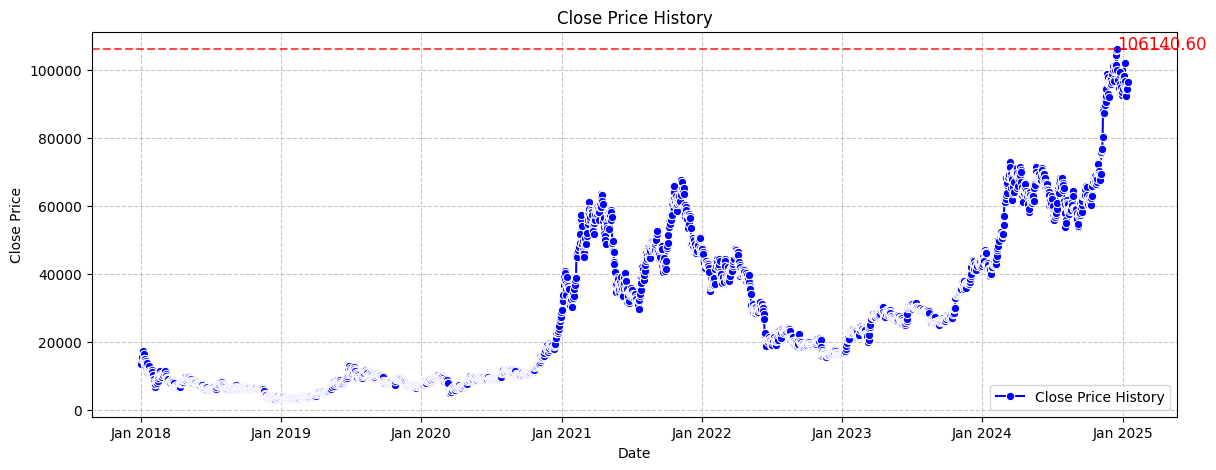

In [33]:
plt.figure(figsize=(14, 5))
sns.lineplot(data=data, x=data.index, y='Close', label='Close Price History', marker ='o', color='blue')

max_price = data['Close'].max()
max_price_date = data['Close'].idxmax()

# Annotate the highest price
plt.annotate(f'{max_price:.2f}',
            xy=(max_price_date, max_price),
            xytext=(max_price_date, max_price + 2),
            fontsize=12, color='red')

plt.axhline(max_price, linestyle='--', color='red', alpha=0.7)
plt.title('Close Price History')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

## 4. Preprocessing

karena datanya memiliki sangat banyak digit, maka akan kita lakukan proses ekstraksi terlebih dahulu agar proses komputasinya lebih sedikit

In [36]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))
scaled_data

array([[0.10126384],
       [0.11413897],
       [0.1162662 ],
       ...,
       [0.88676648],
       [0.88703941],
       [0.90664532]])

In [38]:
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range (len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        labels.append(data[i + sequence_length, 0])
    return np.array(sequences), np.array(labels)


In [41]:
sequence_length = 30 # 30 hari kedepan

# disini kita melakukan split data untuk train dan test
train_size = int(len(scaled_data) * 0.8) # 80% untuk data training
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:] # sisanya 20% untuk data testing

X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

## 5. Training Data (LSTM)

In [43]:
model = Sequential()  

# First Layer LSTM
model.add(Input(shape=(X_train.shape[1], 1)))  
model.add(LSTM(units=50, return_sequences=True))  
model.add(Dropout(0.2))  

# Second Layer LSTM
model.add(LSTM(units=50, return_sequences=False))  
model.add(Dropout(0.2))  

# Dense Layer
model.add(Dense(units=25))  
model.add(Dense(units=1))  


In [44]:
model.compile(optimizer='adam', loss='mean_squared_error')  
history = model.fit(X_train, y_train, epochs=70, batch_size=84, validation_data=(X_test, y_test))  

Epoch 1/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0188 - val_loss: 0.0057
Epoch 2/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0018 - val_loss: 0.0038
Epoch 3/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 4/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 5/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.9002e-04 - val_loss: 0.0012
Epoch 6/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 8.2083e-04 - val_loss: 0.0021
Epoch 7/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 7.7858e-04 - val_loss: 0.0018
Epoch 8/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 7.1715e-04 - val_loss: 0.0034
Epoch 9/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 8.6700e-04 - val_loss: 0.0021
Epoch 10/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 8.5772e-04 - val_loss: 0.0025
Epoch 11/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 6.1992e-04 - val_loss: 0.0025
Epoch 12/70
25/25 ━━━━━━━━━━━━━━━━━

jika nilai mse nya rendah maka terbilang bagus, namun jika semakin tinggi maka kurang bagus

## 6. Model Evaluation

In [45]:
predictions = model.predict(X_test)  
predictions = scaler.inverse_transform(predictions)  
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))  
mse = mean_squared_error(y_test_scaled, predictions)  
print(f"Mean Squared Error: {mse}")  

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Mean Squared Error: 5816338.024110553


## 7. Prediction Price vs Actual Price

In [48]:
last_30_days = data['Close'][-sequence_length:].values.reshape(-1, 1)  
last_30_days_scaled = scaler.transform(last_30_days)  
X_predict = []  
X_predict.append(last_30_days_scaled)  

X_predict = np.array(X_predict)  
X_predict = np.reshape(X_predict, (X_predict.shape[0], X_predict.shape[1], 1))  
predicted_price = model.predict(X_predict)  
predicted_price = scaler.inverse_transform(predicted_price)  

print(f"Predicted Bitcoin Price: {predicted_price[0][0]}")  


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Bitcoin Price: 92861.9140625


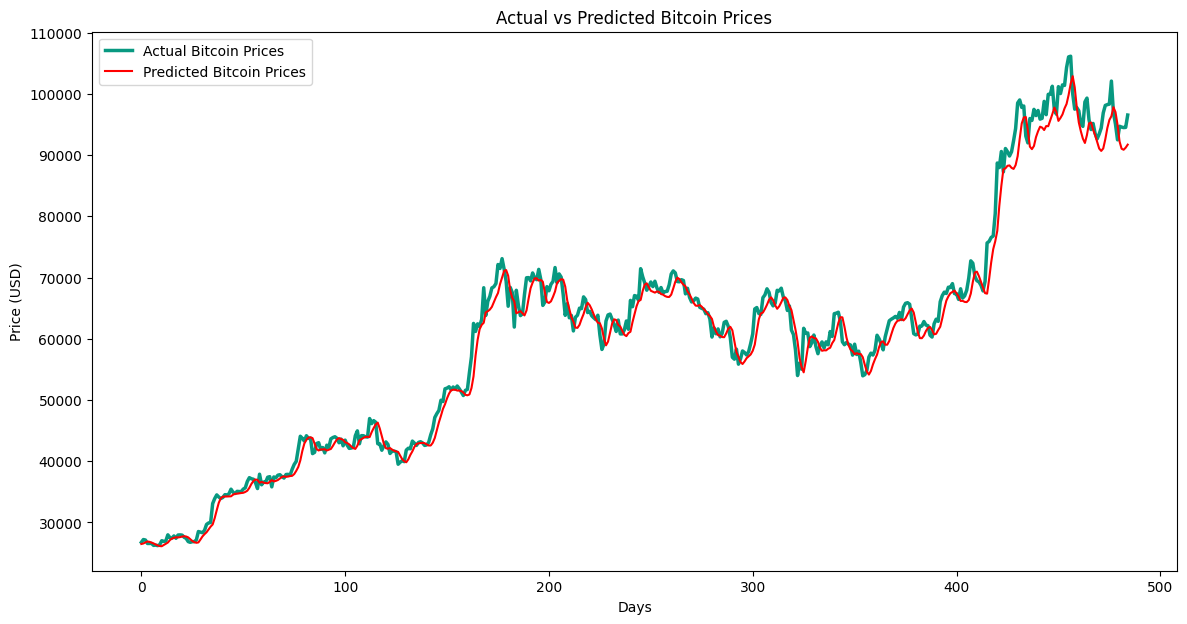

In [50]:
plt.figure(figsize=(14, 7))  

plt.plot(y_test_scaled, label='Actual Bitcoin Prices', color='#089981', linewidth=2.5)  
plt.plot(predictions, label='Predicted Bitcoin Prices', color='red', linewidth=1.5)  

plt.title('Actual vs Predicted Bitcoin Prices')  
plt.xlabel('Days')  
plt.ylabel('Price (USD)')  
plt.legend()  

plt.show()  


## 8. Prediction Future Price 1 Month

In [52]:
future_days = 30  

last_30_days = data['Close'][-sequence_length:].values.reshape(-1, 1)  
last_30_days_scaled = scaler.transform(last_30_days)  
future_predictions = []  

for i in range(future_days):  
    X_predict = []  
    X_predict.append(last_30_days_scaled)  
    X_predict = np.array(X_predict)  
    X_predict = np.reshape(X_predict, (X_predict.shape[0], X_predict.shape[1], 1))  

    predicted_price = model.predict(X_predict)  
    predicted_price_unscaled = scaler.inverse_transform(predicted_price)  

    future_predictions.append(predicted_price_unscaled[0, 0])  

    new_scaled_data = np.append(last_30_days_scaled[1:], predicted_price, axis=0)  
    last_30_days_scaled = new_scaled_data.reshape(-1, 1)  

future_dates = pd.date_range(start=data.index[-1], periods=future_days+1, freq='D')[1:]  


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

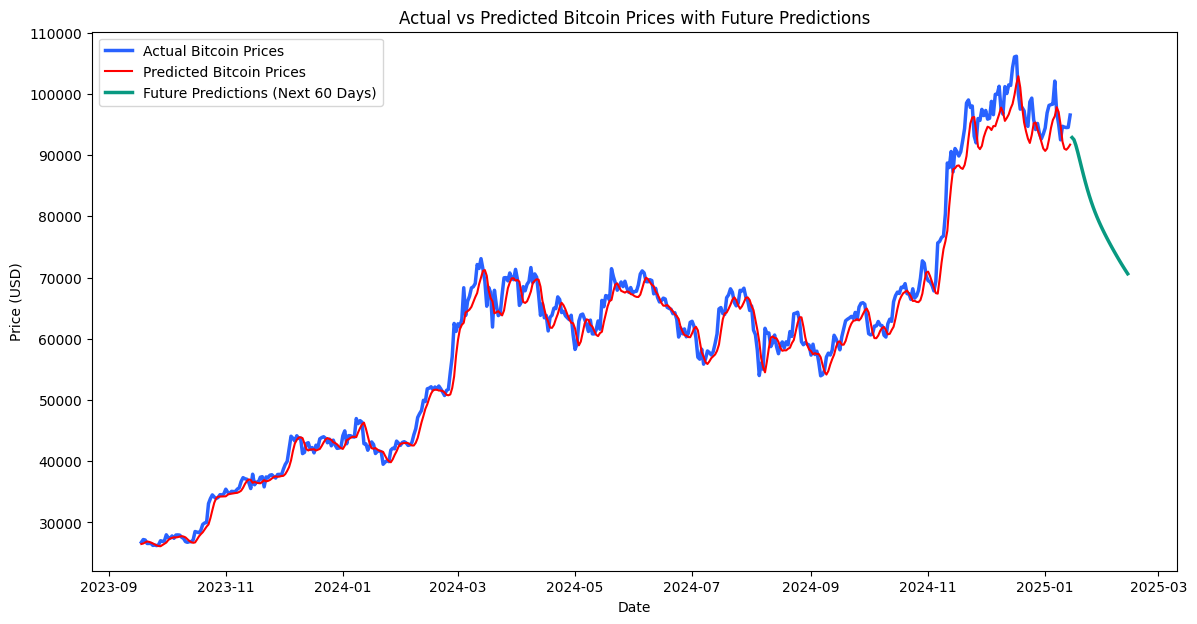

In [ ]:
plt.figure(figsize=(14, 7))  

plt.plot(data.index[-len(y_test_scaled):], y_test_scaled, label='Actual Bitcoin Prices', color='#2962ff', linewidth=2.5)  
plt.plot(data.index[-len(y_test_scaled):], predictions, label='Predicted Bitcoin Prices', color='red', linewidth=1.5)  
plt.plot(future_dates, future_predictions, label='Future Predictions (Next 30 Days)', color='#089981', linewidth=2.5)  

plt.title('Actual vs Predicted Bitcoin Prices with Future Predictions')  
plt.xlabel('Date')  
plt.ylabel('Price (USD)')  
plt.legend()  

plt.show()  


In [55]:
future_predictions_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Price': future_predictions
})

future_predictions_df

,Date,Predicted Price
0,2025-01-15 00:00:00+00:00,92861.914062
1,2025-01-16 00:00:00+00:00,92505.945312
2,2025-01-17 00:00:00+00:00,91589.078125
3,2025-01-18 00:00:00+00:00,90433.085938
4,2025-01-19 00:00:00+00:00,89184.601562
5,2025-01-20 00:00:00+00:00,87920.078125
6,2025-01-21 00:00:00+00:00,86683.406250
7,2025-01-22 00:00:00+00:00,85500.750000
8,2025-01-23 00:00:00+00:00,84386.609375
9,2025-01-24 00:00:00+00:00,83347.312500


### Perlu diingat, tujuan ini hanya untuk edukasi, bukan melakukan prediksi yang sebenarnya, karena dunia crypto lebih kompleks  